In [56]:
import sys
sys.path.append("../")

from photutils.aperture import RectangularAperture, EllipticalAnnulus

import cubespa

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import interactive

import numpy as np

from tqdm import tqdm

from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

cubespa.plotting.pyplot_style()

In [2]:
phangs_fn = "../personal/NGC4858_12m+7m_co21_pbcorr_crop.fits"
phangs_mms = "../personal/mm_out_phangs/NGC4858_PHANGS.3.0_1.9"

stellar_ra, stellar_dec = 194.75871125601466, 28.115690196322245

phangs = cubespa.CubeSPA(phangs_fn, mom_maps=phangs_mms, limits="auto", center=(stellar_ra, stellar_dec, "radec"), eps=0.21)


In [3]:
def quadrants(q1_angle, offset = 90):
    return [q1_angle + i * 90 + offset for i in range(4)]

def halfline_points(cent, length, angle):

    p1 = (cent[0] , cent[0] + length * np.cos(angle))
    p2 = (cent[1], cent[1] + length * np.sin(angle))
    
    return (p1, p2)


def line_points(cent, length, angle):
    p1 = (cent[0] - length * np.cos(angle), cent[0] + length * np.cos(angle))
    p2 = (cent[1] - length * np.sin(angle), cent[1] + length * np.sin(angle))

    
    return (p1, p2)


def sample_ellipse(x, y, a, e, theta, pa, num_points=100):

    # Calculate semiminor axis
    b = a * (1 - e)

    # Parametric equation for the ellipse
    x_coords = x + a * np.cos(theta) * np.cos(pa) - b * np.sin(theta) * np.sin(pa)
    y_coords = y + a * np.cos(theta) * np.sin(pa) + b * np.sin(theta) * np.cos(pa)

    # Return the sampled coordinates as a NumPy array
    return x_coords, y_coords


def beam_ellipse(x, y, a, b, pa, num_points=100):

    theta = np.linspace(0, np.pi * 2, 50)
    # Calculate semiminor axis

    # Parametric equation for the ellipse
    x_coords = x + a * np.cos(theta) * np.cos(pa) - b * np.sin(theta) * np.sin(pa)
    y_coords = y + a * np.cos(theta) * np.sin(pa) + b * np.sin(theta) * np.cos(pa)

    # Return the sampled coordinates as a NumPy array
    return x_coords, y_coords


In [4]:
thetas = (np.linspace(0, 2 * np.pi, 90)) # These thetas are CCW from +ve y-axis
pa_deg, inc_deg = 30, 38
pa, inc =  np.deg2rad(pa_deg + 90), np.deg2rad(inc_deg)

bar_pa = 65

bmaj, bmin, bpa = phangs.beam

data_co = phangs.mom_maps.mom0.data
stellar_x, stellar_y = phangs.center


7.0685834705770345 0.7853981633974483


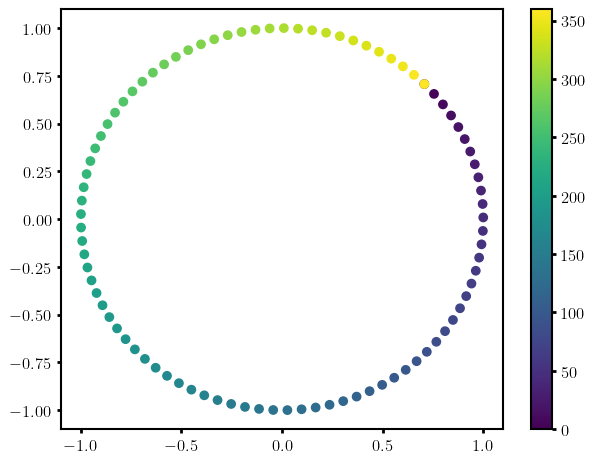

In [53]:
def theta_list(theta_0, clockwise=False, n_samples=90, plot=False, **kwargs):
    outname = cubespa.check_kwarg("outname", None, kwargs)

    theta_max = theta_0 + 2*np.pi

    if clockwise:
        _ = theta_0
        theta_0, theta_max = theta_max, _
    
    print(theta_0, theta_max)

    angles = np.linspace(theta_0, theta_max, n_samples) % (2 * np.pi)

    if plot:
        thetas_norm = np.linspace(0, 2*np.pi, n_samples)
        xs, ys = np.cos(angles), np.sin(angles)
        plt.scatter(xs, ys, c=np.rad2deg(thetas_norm))
        plt.colorbar()
        plt.tight_layout()
        if outname is not None:
            plt.savefig(outname, dpi=100)
            plt.close()
        else:
            plt.show()
    
    return angles
        

thetas = theta_list(np.pi/4, clockwise=True, plot=True)


In [54]:
thetas = (np.linspace(0, 2 * np.pi, 90)) # These thetas are CCW from +ve y-axis
# thetas = np.linspace(0, np.pi, 20)

dist, length = 70, 20
width=10


data_nonans = np.copy(phangs.mom_maps.mom0.data)
data_nonans[np.isnan(phangs.mom_maps.mom0.data)] = 0


# plt.xlim(200, 550)
# plt.ylim(400, 900)

fluxes_outer = []
mean_fluxes_outer = []
flux_stds_outer = []

for i, theta in enumerate(thetas):
    theta_adj = theta # + np.pi/2 # This theta is CCW from +ve x-axis
    px, py = phangs.center[0] + dist * np.cos(theta_adj), phangs.center[1] + dist  * np.sin(theta_adj)

    rect = RectangularAperture((px, py), width, length, theta=theta_adj + np.pi / 2)

    mask = rect.to_mask(method='center').to_image(shape=data_co.shape)
    data_slice = np.copy(data_co)
    data_slice[mask == 0] = np.nan

    fluxes_outer.append(np.nansum(data_slice))
    mean_fluxes_outer.append(np.nanmean(data_slice))
    flux_stds_outer.append(np.nanstd(data_slice))



In [55]:
def theta_range(shape, x0, y0, theta, dtheta):
    ys, xs = np.mgrid[:shape[0], :shape[1]].astype(float)
    xs -= x0
    ys -= y0
    
    thetas = (np.arctan2(ys, xs) ) % (2 * np.pi)

    theta_mask = np.ones(thetas.shape)

    theta_min = (theta - dtheta / 2) % (2 * np.pi)
    theta_max = (theta + dtheta / 2) % (2 * np.pi)
    
    # Adjust for cases where theta_max < theta_min due to wrapping around 2pi
    if theta_max < theta_min:
        # In this case, we need to handle the wrap around.
        theta_mask = np.logical_or(thetas >= theta_min, thetas <= theta_max)
    else:
        # Regular case where the range does not wrap around
        theta_mask = np.logical_and(thetas >= theta_min, thetas <= theta_max)

    return theta_mask.astype(int)


theta_range(phangs.mom_maps.mom0.data.shape, phangs.center[0], phangs.center[1], np.pi / 4, 4 * np. pi / 180)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
def segment_sum(data, radius, pa, angle_min, annulus_width=50):
    #ell_annulus = EllipticalAperture((stellar_x, stellar_y), radius, (radius * (1-eps)), theta = pa)
    ell_annulus = EllipticalAnnulus((stellar_x, stellar_y), radius, radius + annulus_width, 
                                    (radius + annulus_width) * (1-eps), theta = pa)
    
    
    mask = ell_annulus.to_mask(method='center').to_image(shape=data_co.shape)
    data_init_mask = np.copy(data)
    data_init_mask[mask == 0] = np.nan
    
    
    theta_mask = theta_range(data.shape, stellar_x, stellar_y, angle_min - np.pi / 4, np.pi / 2)
    
    data_init_mask[theta_mask == 0] = np.nan
    
    return np.nansum(data_init_mask)
    
    
qs = np.deg2rad(quadrants(75, offset=0))

eps = 0.21
annulus_width = 30
radii = [10, 40, 70, 100, 130, 160]

quadrant_fluxsums = []
for r in radii:
    row_sums = []
    for q in qs:
        row_sums.append(segment_sum(data_co, r, pa, q, annulus_width=200))
    quadrant_fluxsums.append(row_sums)


quadrant_fluxsums = np.asarray(quadrant_fluxsums)

print(quadrant_fluxsums)

[[808.52844   430.74167   412.2507    478.9904   ]
 [386.63745    19.881962    1.063072    1.4727652]
 [247.37187    15.576887    0.          0.       ]
 [148.76698    15.1991825   0.          0.       ]
 [ 31.036644    5.514929    0.          0.       ]
 [  0.          0.          0.          0.       ]]


In [65]:

def process_azimuth(data, radius, pa, eps, thetas, annulus_width=50, trim_nans=False):

    
    ell_annulus = EllipticalAnnulus((stellar_x, stellar_y), radius, radius + annulus_width, 
                                    (radius + annulus_width) * (1-eps), theta = pa)
    mask = ell_annulus.to_mask(method='center').to_image(shape=data_co.shape)
    
    data_init_mask = np.copy(data)
    data_init_mask[mask == 0] = np.nan

    fluxes, flux_stds = [], []

    for i, theta in tqdm(enumerate(thetas[:])):
    
        theta_mask = theta_range(data_co.shape, stellar_x, stellar_y, theta, 5 * np.pi / 180)
    
        this_data = np.copy(data_init_mask)
        this_data[theta_mask == 0] = np.nan
        try:
            med, std = np.nanmedian(this_data), np.nanstd(this_data)
        except RuntimeWarning:
            med, std = np.nan, np.nan
            
        fluxes.append(med)
        flux_stds.append(std)

    if trim_nans:
        fluxes = np.array(fluxes)
        fluxes[np.isnan(fluxes)] = 0

        flux_stds = np.array(flux_stds)
        flux_stds[np.isnan(flux_stds)] = 0
    
    return (np.array(fluxes), np.array(flux_stds), ell_annulus)


0 6.283185307179586


90it [00:00, 268.52it/s]
90it [00:00, 291.29it/s]
90it [00:00, 286.20it/s]
90it [00:00, 261.99it/s]
90it [00:00, 276.75it/s]
90it [00:00, 292.71it/s]
90it [00:00, 288.37it/s]
90it [00:00, 283.51it/s]


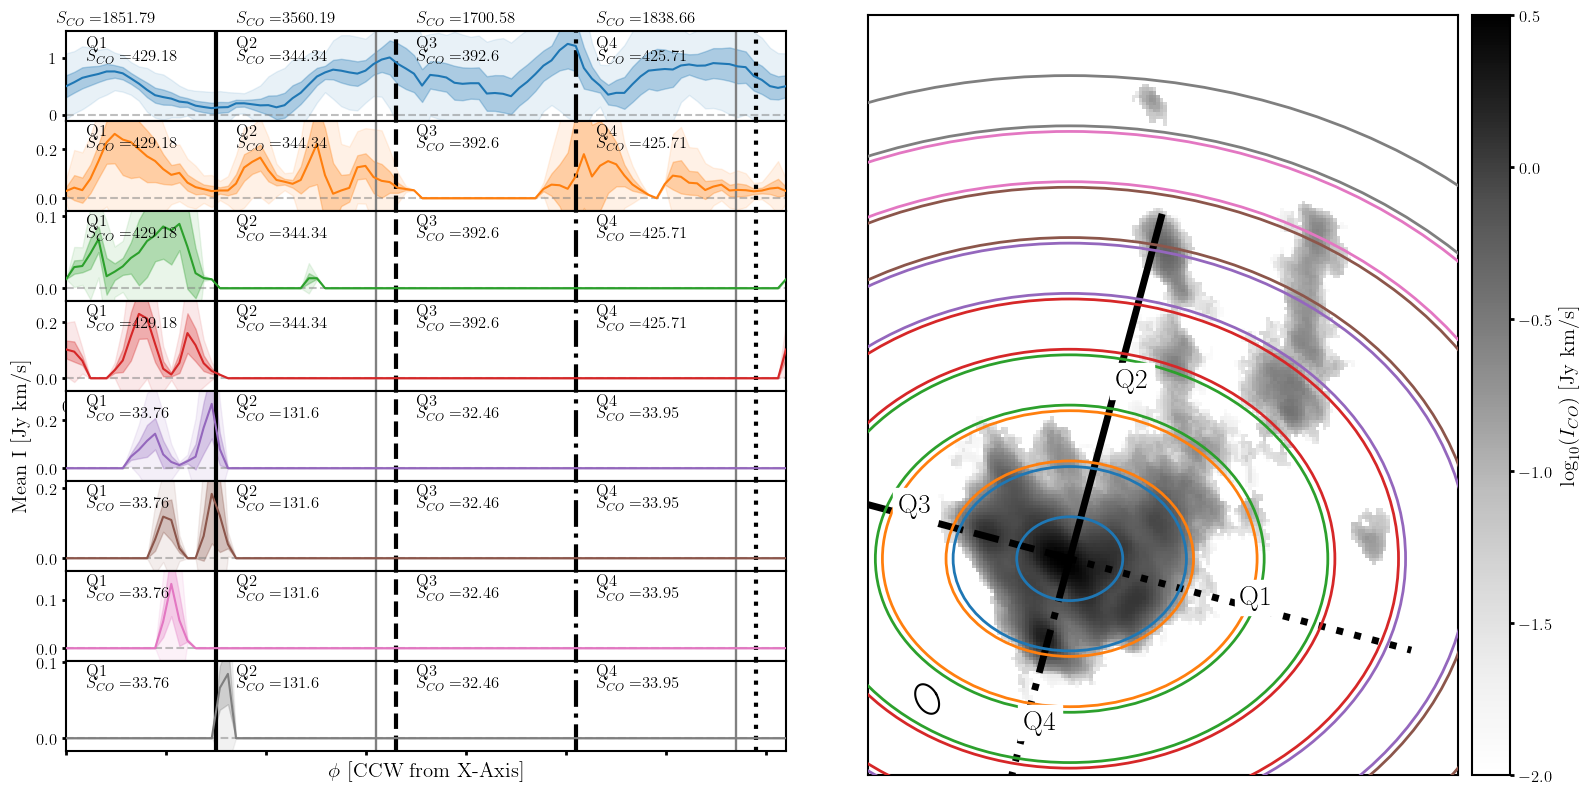

In [64]:
def azimuthal_plot(data, cubespa_obj, radii, theta_0 = 0, clockwise=True, outname=None, theta_samples=90, **kwargs):

    # TODO generate these automatically from theta_0 and clockwise
    thetas_uniform = np.linspace(0, 360, theta_samples)
    thetas = theta_list(theta_0, clockwise=clockwise, n_samples=theta_samples)
    thetas_adj = np.rad2deg(thetas)

    eps = cubespa_obj.eps if cubespa_obj.eps is not None else 0.
    pa = cubespa_obj.position_angle if cubespa_obj.position_angle is not None else 0

    colors = cubespa.check_kwarg("colors", list(mcolors.TABLEAU_COLORS.values()), kwargs) 
    figsize = cubespa.check_kwarg("figsize", (16, 8), kwargs)
    plot_fiducial = cubespa.check_kwarg("plot_fiducial", False, kwargs)
    xlabel, ylabel = cubespa.check_kwarg("xlabel", r'$\phi$ [CCW from X-Axis]', kwargs), cubespa.check_kwarg("ylabel", r'Mean I [Jy km/s]', kwargs)
    # Set 
    if cubespa_obj.limits is None:
        lims = cubespa.check_kwarg("limits", [0, data.shape[0], 0, data.shape[1]], kwargs) 
    else:
        lims = cubespa.pad_limits(cubespa_obj.limits, padding=10)
    xmin, xmax, ymin, ymax = lims
    dx, dy = xmax - xmin, ymax - ymin

    vmin, vmax = cubespa.check_kwarg("vlims", [-50, 50], kwargs)
    cmap = cubespa.check_kwarg("cmap", "viridis", kwargs)
    log_img = cubespa.check_kwarg("log_img", False, kwargs)

    colorbar_label = cubespa.check_kwarg("colorbar_label", ylabel, kwargs) # Just use the ylabel from the azimuthal plots if not otherwise specified

    styles = ['solid', 'dashed', 'dashdot', 'dotted']

    qs = quadrants(75, offset=0)

    # Get all flux sets and quadrant sums
    sets, quadrant_fluxsums = [], []
    for r in radii:
        sets.append(process_azimuth(data_co, r, pa, eps, thetas, annulus_width=18, trim_nans=True))
        row_sums = []
        for q in qs:
            row_sums.append(segment_sum(data_co, r, pa, q, annulus_width=annulus_width))
            quadrant_fluxsums.append(row_sums)


    fig = plt.figure(figsize=figsize, facecolor="white")
    
    xwidth = 0.45
    yheight, yspacing, ymin_pad = 0.90 / len(sets), 0, 0.060

    axes = []
    for i in range(len(sets) -1, -1, -1):
        axes.append(fig.add_axes([0.05, ymin_pad + i * (yheight + yspacing), xwidth, yheight]))
    img_ax = fig.add_axes([0.52, 0.03, 0.435, 0.95])

    
    # Plot all azimuthal profiles and all the quadrant stuff
    for i, set in enumerate(sets):

        flux_min, flux_max = np.min(set[0]), np.max(set[0])
        df = flux_max - flux_min
        if df > 1e-5:
            axes[i].set_ylim(flux_min - df/5, flux_max + df/5)

        color = colors[i % len(colors)] # Modulus to allow us to cycle colors

        axes[i].plot(thetas_uniform, set[0], color=color, zorder=3)
        axes[i].fill_between(thetas_uniform, set[0] - set[1], set[0] + set[1], color=color, zorder=2, alpha=0.3)
        axes[i].fill_between(thetas_uniform, set[0] - 3 * set[1], set[0] + 3 * set[1], color=color, zorder=2, alpha=0.1)
    
        axes[i].axhline(0, ls="dashed", color="Grey", zorder=2, alpha=0.5)
        
        axes[i].set_xlim(0, 360)
        ylims = axes[i].get_ylim()

        # Plot fiducial velocities
        if plot_fiducial and i != 0:
            axes[i].plot(thetas_adj, sets[0][0], color="Grey", zorder=2, alpha=0.5)
    
        if i is not len(set):
            axes[i].tick_params(labelbottom=False)    

        for j, q in enumerate(qs):
            axes[i].axvline(q, color="black", linestyle=styles[j], lw=3)
            
            text_x = np.max([q - 80, 10])
            axes[i].text(text_x, ylims[1] * 0.80, f'Q{j + 1}')
            
            qsum = np.round(quadrant_fluxsums[i][j], 2)
            axes[i].text(text_x, ylims[1] * 0.65, r'$S_{CO} =$' + str(qsum))            


            axes[i].axvline(bar_pa + 90, color="Grey")
            axes[i].axvline(bar_pa + 90 + 180, color="Grey")
    

    axes[int(len(axes) / 2)].set_ylabel(ylabel, fontsize=15)
    axes[-1].set_xlabel(xlabel, fontsize=15)

    # Add and clean up the image plot
    if log_img:
        img_map = img_ax.imshow(np.log10(data), origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        img_map = img_ax.imshow(data, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    
    img_ax.set_xlim(xmin, xmax)
    img_ax.set_ylim(ymin, ymax)

    for i, q in enumerate(qs):
        ylims = axes[0].get_ylim()
        
        qsum = np.sum(np.transpose(quadrant_fluxsums)[i])
        qsum = np.round(qsum, 2)
        
        axes[0].text(q - 80, ylims[1] * 1.1, r'$S_{CO}=$' + str(qsum))
    
        q = np.deg2rad(q)
        points = halfline_points((stellar_x, stellar_y), 100, q)
        img_ax.plot(points[0], points[1], color="black", lw=5, linestyle=styles[i])

        mean_x, mean_y = np.mean(points[0]), np.mean(points[1])
        
        img_ax.text(mean_x, mean_y, f"Q{(i + 1) % 4 + 1}",  fontsize=20, backgroundcolor="white", zorder=4)
        
    img_ax.set_xticks([])
    img_ax.set_yticks([])

    for i, s in enumerate(sets):
        s[2].plot(color=colors[i % len(colors)], lw=2, ax=img_ax, zorder=3)

    cb = plt.colorbar(mappable=img_map, ax=img_ax, fraction=0.06, pad=0.02)
    cb.set_label(label=colorbar_label, fontsize=15)
    
    # Draw beam
    if cubespa_obj.beam is not None:
        bmaj, bmin  = cubespa_obj.get_beam_pix()
        bpa = cubespa_obj.beam[2]
        beam_x, beam_y = beam_ellipse(xmin + dx/10, ymin + dy/10, bmaj /2, bmin /2, np.deg2rad(bpa))
        img_ax.plot(beam_x, beam_y, color="black", zorder=2)
    
    if outname is not None:
        plt.savefig(outname, dpi=200)
        plt.savefig(f"{outname.removesuffix('.pdf')}.png", dpi=200)
        plt.close()
    else:
        plt.show()

azimuthal_plot(data_co, phangs, np.arange(10, 170, 20) + 5, log_img=True, vlims=[-2, 0.5], cmap="Greys", colorbar_label=r'$\log_{10}(I_{CO})$ [Jy km/s]', clockwise=False)